# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

In [138]:
# Write your code here
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score
import seaborn as sns
import tensorflow as tf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

<h2> Loading the Dataset

In [2]:
df = pd.read_csv('sudeste.csv')
df.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,2007-11-06,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,2007-11-06,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,2007-11-06,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,2007-11-06,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,2007-11-06,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


<h2> Data Preprocessing

In [3]:
df['prov'].value_counts()

MG    4710632
SP    2746440
RJ    1617624
ES     704472
Name: prov, dtype: int64

In [4]:
df_rj = df[df['prov'] ==  'RJ']
df_rj['city'].value_counts()

Rio de Janeiro           302352
Campos dos Goytacazes    160584
Seropédica               143376
Duque de Caxias          122256
Cambuci                  121536
Macaé                     87888
Arraial do Cabo           87840
Valença                   87768
Resende                   87720
Petrópolis                87168
Teresópolis               86928
Parati                    86496
São Gonçalo               78048
Nova Friburgo             52944
Silva Jardim               9600
Saquarema                  9480
Rio Claro                  2880
Três Rios                  2760
Name: city, dtype: int64

In [5]:
df_rj = df[df['city'] == 'Rio de Janeiro']
df_rj[['mdct', 'date']] = df_rj[['mdct', 'date']].apply(pd.to_datetime)

C:\Users\Jaymarq\AppData\Local\Temp\ipykernel_29840\237677400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rj[['mdct', 'date']] = df_rj[['mdct', 'date']].apply(pd.to_datetime)


In [260]:
filtered_rj = df_rj[df_rj['date'].between('2010-01-01', '2014-12-31')]
filtered_rj

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
5699192,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 00:00:00,2010-01-01,...,24.7,22.2,23.7,21.6,89.0,89.0,84.0,2.2,291.0,14.5
5699193,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 01:00:00,2010-01-01,...,24.4,22.2,23.7,21.7,88.0,89.0,86.0,3.3,294.0,7.3
5699194,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 02:00:00,2010-01-01,...,24.5,22.4,24.0,22.1,90.0,90.0,88.0,2.0,339.0,6.2
5699195,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 03:00:00,2010-01-01,...,24.0,22.2,23.8,22.1,90.0,90.0,90.0,3.0,3.0,5.1
5699196,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 04:00:00,2010-01-01,...,24.6,22.2,23.8,21.9,85.0,90.0,85.0,4.6,2.0,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982971,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 19:00:00,2014-12-31,...,28.5,22.9,27.4,20.9,69.0,74.0,65.0,1.4,279.0,4.8
6982972,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 20:00:00,2014-12-31,...,29.1,22.6,27.3,20.1,62.0,74.0,58.0,1.8,320.0,4.8
6982973,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 21:00:00,2014-12-31,...,29.0,21.1,28.3,20.2,63.0,65.0,60.0,1.0,5.0,5.4
6982974,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 22:00:00,2014-12-31,...,28.6,21.6,28.0,20.9,67.0,68.0,63.0,2.7,7.0,8.1


In [261]:
filtered_rj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131472 entries, 5699192 to 6982975
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   wsid    131472 non-null  int64         
 1   wsnm    131472 non-null  object        
 2   elvt    131472 non-null  float64       
 3   lat     131472 non-null  float64       
 4   lon     131472 non-null  float64       
 5   inme    131472 non-null  object        
 6   city    131472 non-null  object        
 7   prov    131472 non-null  object        
 8   mdct    131472 non-null  datetime64[ns]
 9   date    131472 non-null  datetime64[ns]
 10  yr      131472 non-null  int64         
 11  mo      131472 non-null  int64         
 12  da      131472 non-null  int64         
 13  hr      131472 non-null  int64         
 14  prcp    15721 non-null   float64       
 15  stp     131472 non-null  float64       
 16  smax    131472 non-null  float64       
 17  smin    131472 non-nul

<h3> Removing Rows with Zero Values

In [263]:
for column in ['temp', 'tmax', 'tmin']:
    zero_count = (filtered_rj[column].eq(0)).sum()
    print(f"Zero values in '{column}' column: {zero_count}")

Zero values in 'temp' column: 3677
Zero values in 'tmax' column: 3700
Zero values in 'tmin' column: 3700


In [264]:
filtered_rj = filtered_rj[(filtered_rj['temp'] != 0) & (filtered_rj['tmin'] != 0) & (filtered_rj['tmax'] != 0)]
filtered_rj

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
5699192,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 00:00:00,2010-01-01,...,24.7,22.2,23.7,21.6,89.0,89.0,84.0,2.2,291.0,14.5
5699193,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 01:00:00,2010-01-01,...,24.4,22.2,23.7,21.7,88.0,89.0,86.0,3.3,294.0,7.3
5699194,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 02:00:00,2010-01-01,...,24.5,22.4,24.0,22.1,90.0,90.0,88.0,2.0,339.0,6.2
5699195,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 03:00:00,2010-01-01,...,24.0,22.2,23.8,22.1,90.0,90.0,90.0,3.0,3.0,5.1
5699196,372,MARAMBAIA,9.0,-23.050334,-43.595685,A602,Rio de Janeiro,RJ,2010-01-01 04:00:00,2010-01-01,...,24.6,22.2,23.8,21.9,85.0,90.0,85.0,4.6,2.0,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6982971,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 19:00:00,2014-12-31,...,28.5,22.9,27.4,20.9,69.0,74.0,65.0,1.4,279.0,4.8
6982972,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 20:00:00,2014-12-31,...,29.1,22.6,27.3,20.1,62.0,74.0,58.0,1.8,320.0,4.8
6982973,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 21:00:00,2014-12-31,...,29.0,21.1,28.3,20.2,63.0,65.0,60.0,1.0,5.0,5.4
6982974,388,FORTE DE COPACABANA,26.0,-22.988286,-43.190436,A652,Rio de Janeiro,RJ,2014-12-31 22:00:00,2014-12-31,...,28.6,21.6,28.0,20.9,67.0,68.0,63.0,2.7,7.0,8.1


In [265]:
for column in ['temp', 'tmax', 'tmin']:
    zero_count = (filtered_rj[column].eq(0)).sum()
    print(f"Zero values in '{column}' column: {zero_count}")

Zero values in 'temp' column: 0
Zero values in 'tmax' column: 0
Zero values in 'tmin' column: 0


<h2> TSA and ACF

In [266]:
def plot_avg_temp_monthly(dataset):
    dataset['date'] = pd.to_datetime(dataset['date'])
    monthly_avg_temp = dataset.groupby(dataset['date'].dt.to_period('M'))[['temp', 'tmax', 'tmin']].mean()

    plt.figure(figsize=(22,10))
    plt.plot(monthly_avg_temp.index.to_timestamp(), monthly_avg_temp['temp'], label='Average Temp', color='green')
    plt.plot(monthly_avg_temp.index.to_timestamp(), monthly_avg_temp['tmax'], label='Average Max Temp', color='red')
    plt.plot(monthly_avg_temp.index.to_timestamp(), monthly_avg_temp['tmin'], label='Average Min Temp', color='blue')
    plt.title('Average Monthly Temperature')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)

C:\Users\Jaymarq\AppData\Local\Temp\ipykernel_29840\858804484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = pd.to_datetime(dataset['date'])


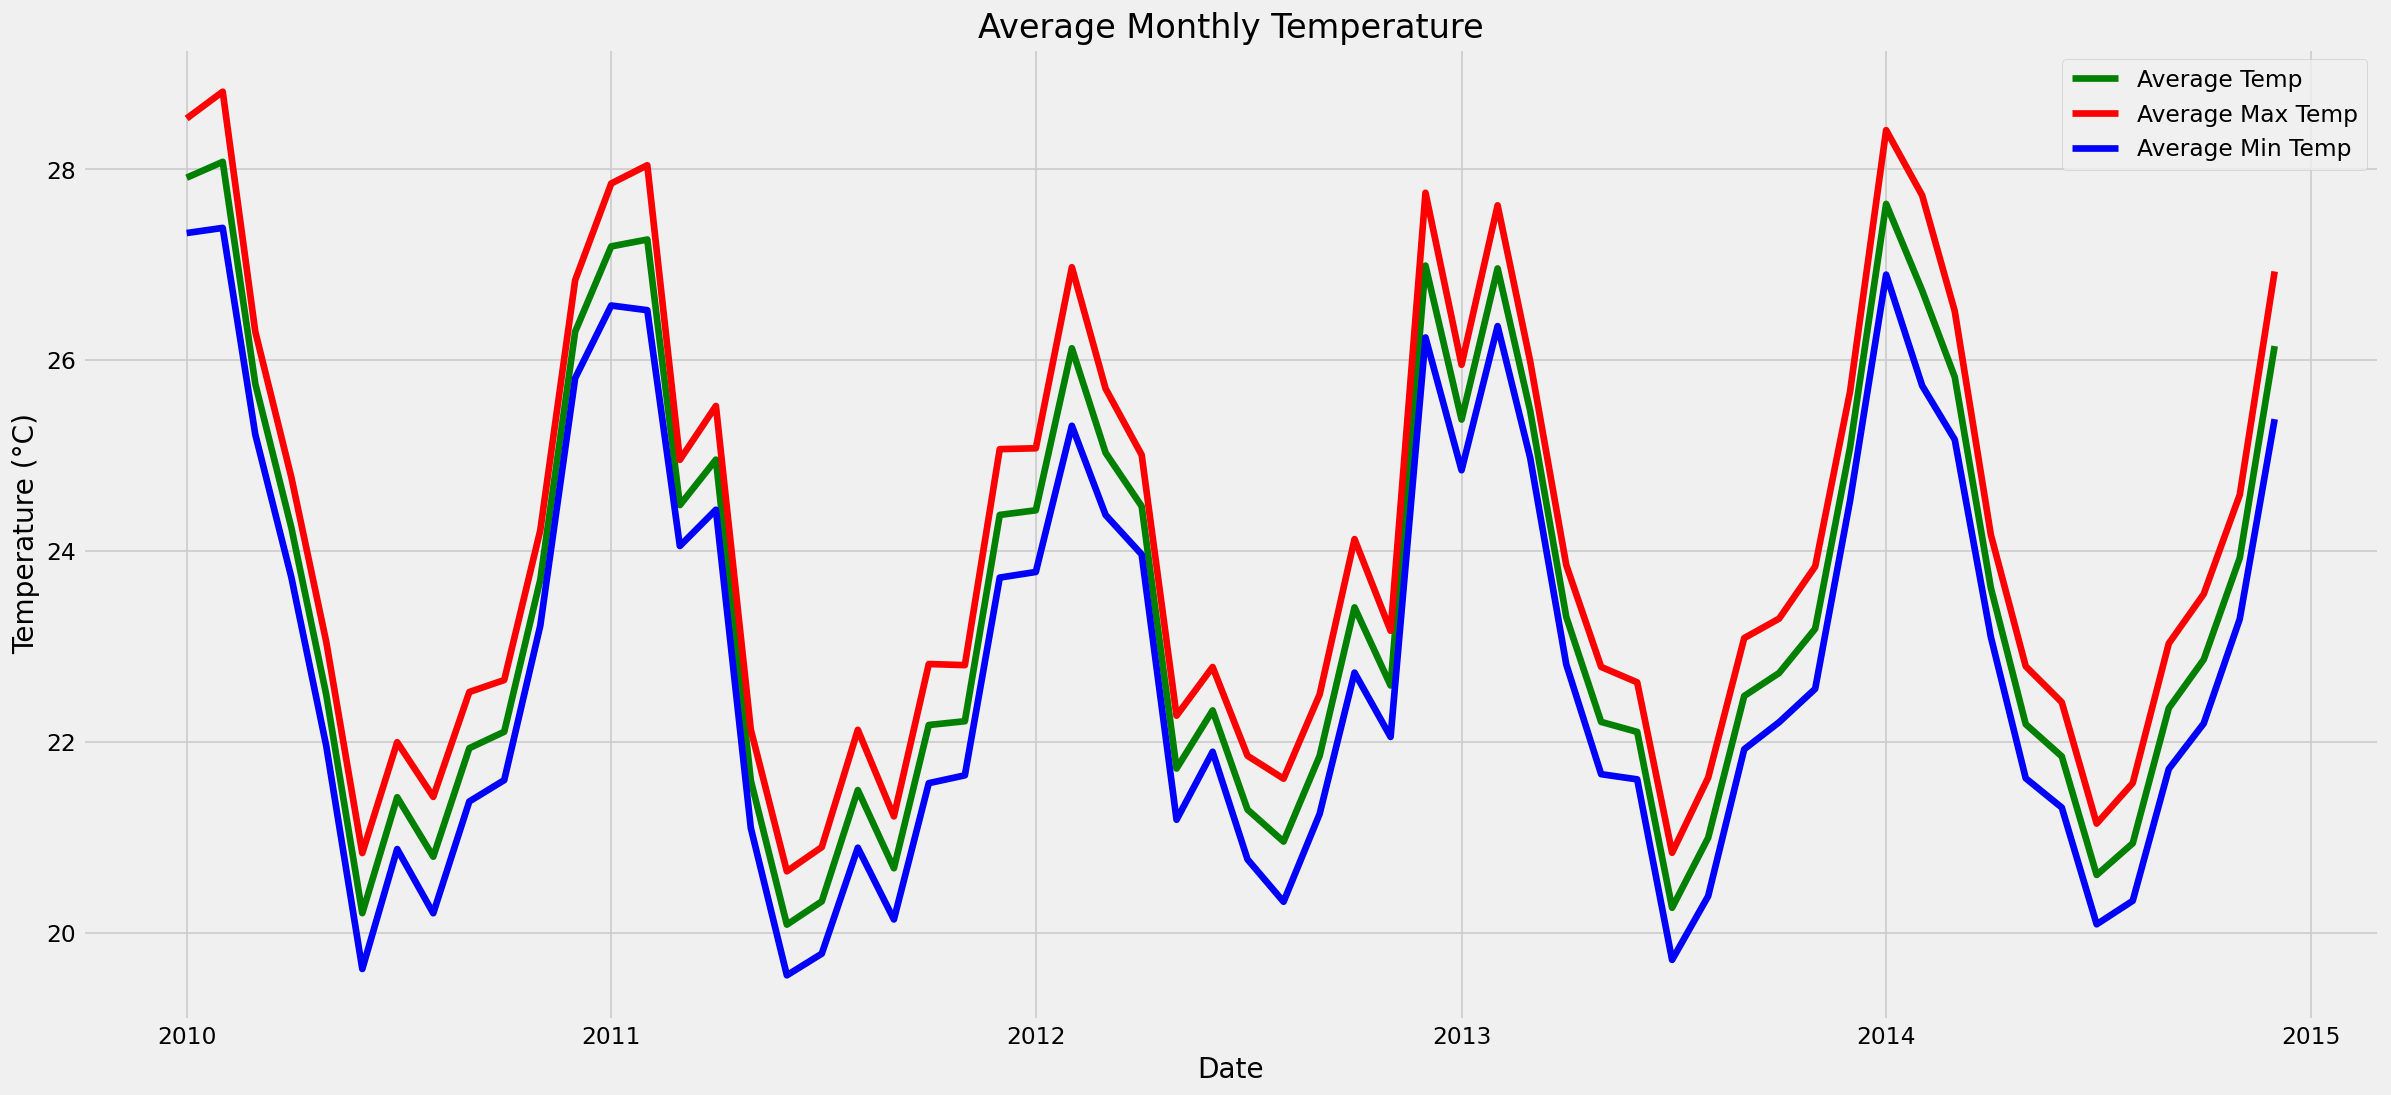

In [267]:
plot_avg_temp_monthly(filtered_rj)

In [268]:
def plot_acf_pacf_temp(dataset):
    dataset['date'] = pd.to_datetime(dataset['date'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22,10))
    plot_acf(dataset['temp'], ax=ax1, lags=50)
    ax1.set_title('Autocorrelation of Temperature')
    plot_pacf(dataset['temp'], ax=ax2, lags=50)
    ax2.set_title('Partial Autocorrelation of Temperature')
    plt.tight_layout()
    plt.show()

C:\Users\Jaymarq\AppData\Local\Temp\ipykernel_29840\2884084506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = pd.to_datetime(dataset['date'])
C:\Users\Jaymarq\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


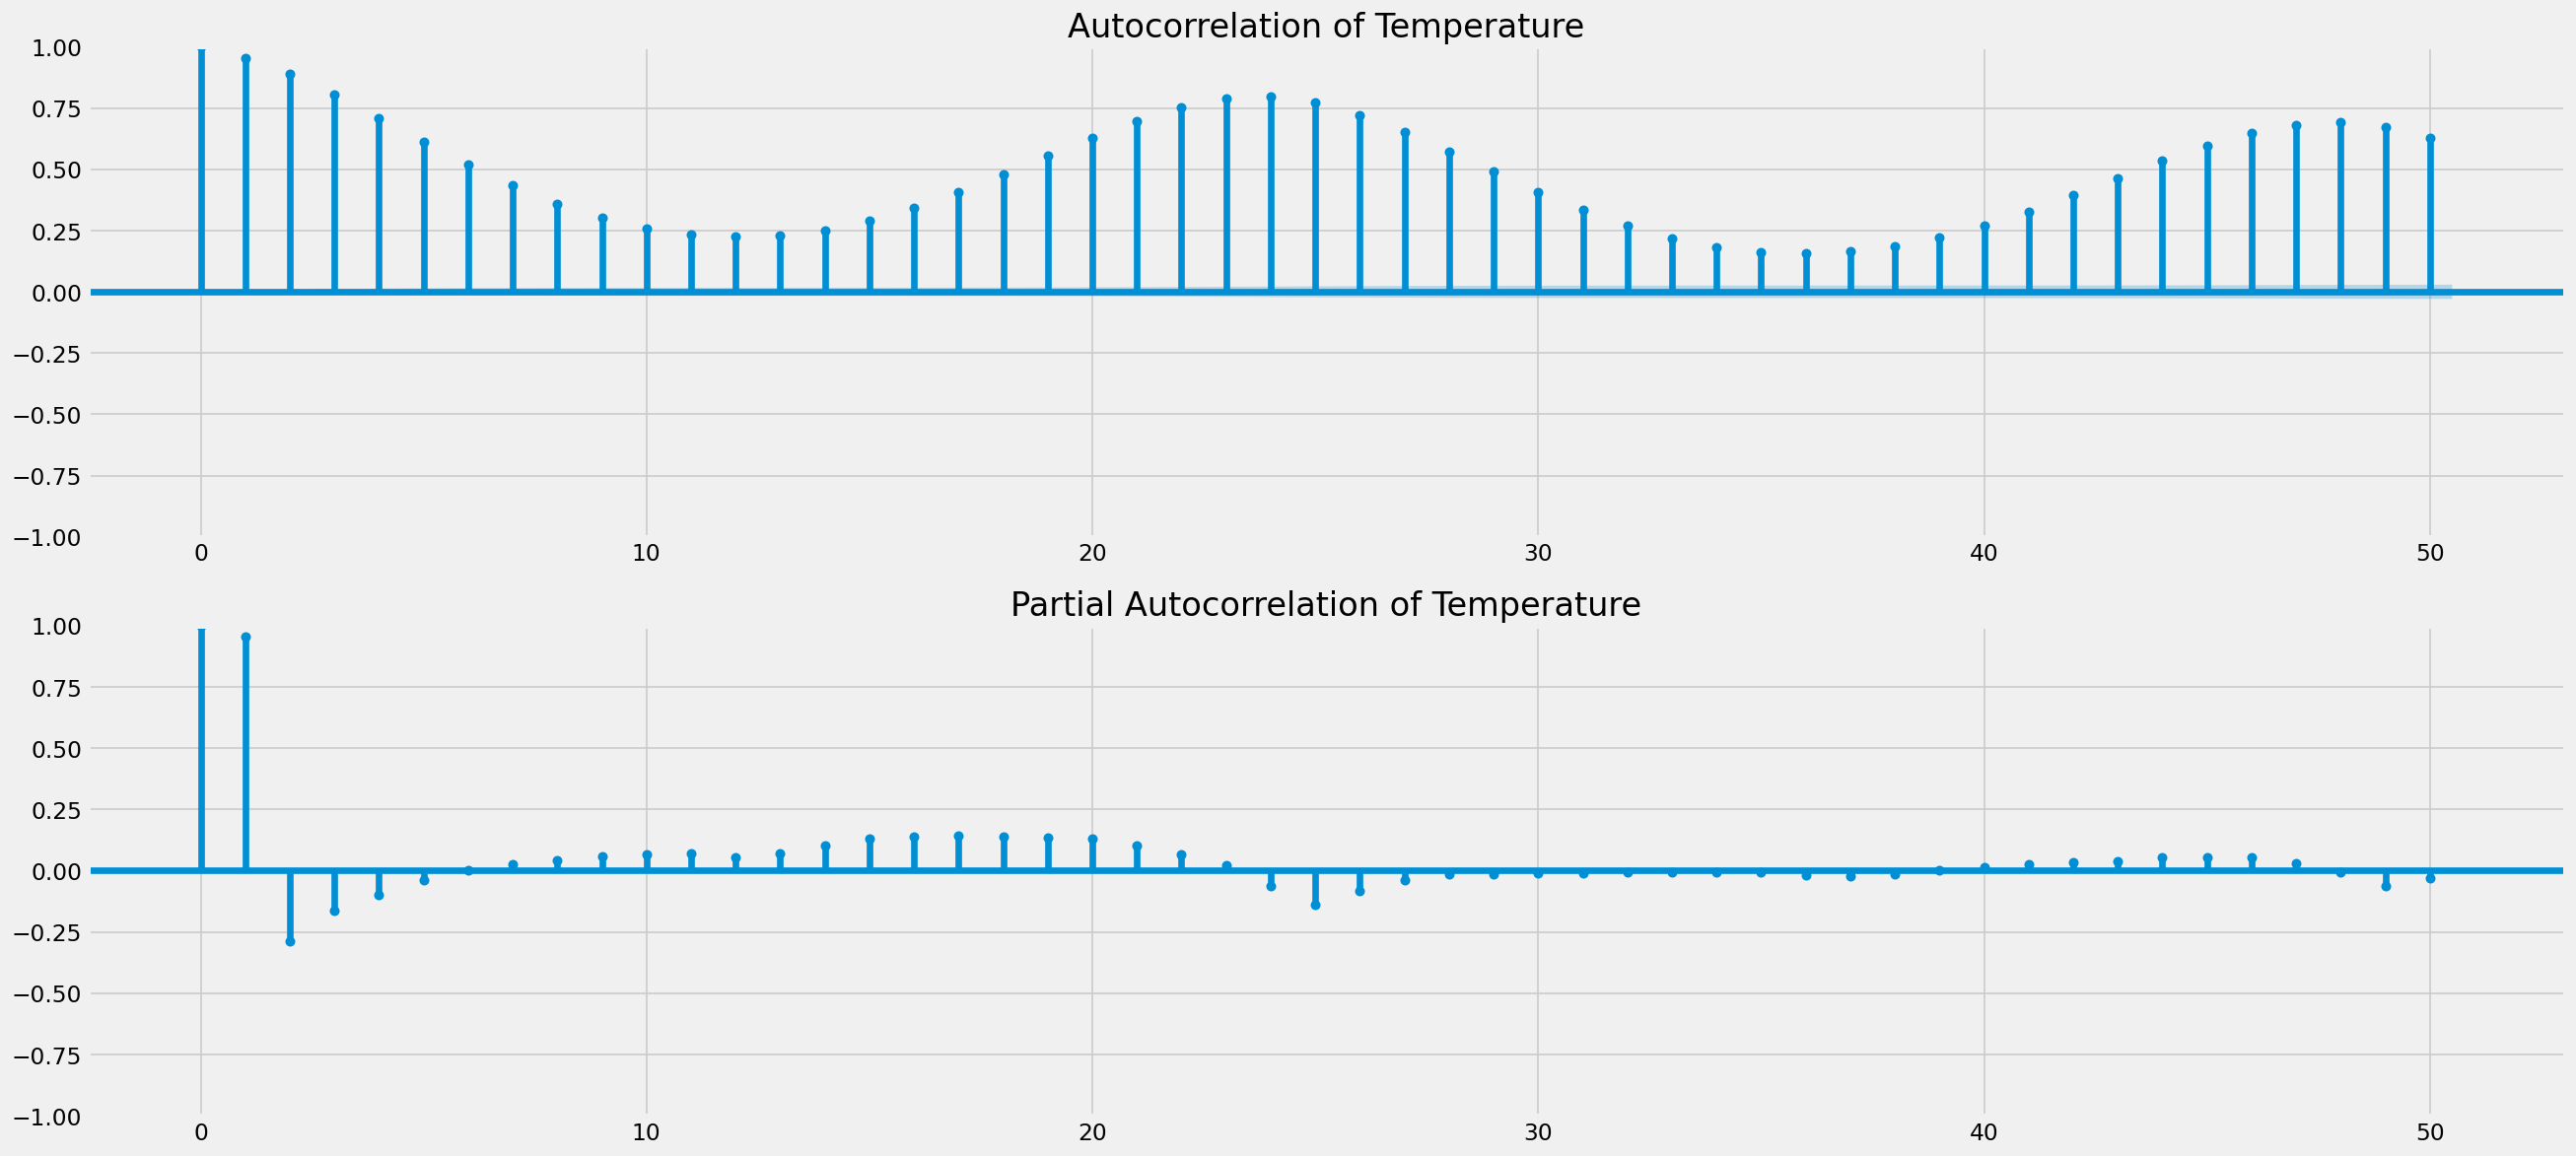

In [269]:
plot_acf_pacf_temp(filtered_rj)

<h2> Splitting Train-Test Data

In [270]:
f_df = filtered_rj[['mdct', 'temp','tmax','tmin']]
f_df['mdct'] = pd.to_datetime(f_df['mdct'])

C:\Users\Jaymarq\AppData\Local\Temp\ipykernel_29840\1126591552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_df['mdct'] = pd.to_datetime(f_df['mdct'])


In [271]:
f_df.set_index('mdct', inplace=True)

In [272]:
f_df.head()

,temp,tmax,tmin
mdct,,,
2010-01-01 00:00:00,23.7,24.7,23.7
2010-01-01 01:00:00,24.4,24.4,23.7
2010-01-01 02:00:00,24.0,24.5,24.0
2010-01-01 03:00:00,23.8,24.0,23.8
2010-01-01 04:00:00,24.6,24.6,23.8


In [273]:
f_df.describe()

,temp,tmax,tmin
count,127770.000000,127770.000000,127770.000000
mean,23.433706,24.050816,22.846840
std,4.015728,4.170352,3.856002
min,8.300000,8.700000,8.100000
25%,20.800000,21.200000,20.400000
50%,23.100000,23.600000,22.600000
75%,25.700000,26.400000,25.000000
max,41.000000,41.600000,40.200000


In [274]:
train_df = f_df['2010':'2013'].resample('M').mean()
train_df = train_df.fillna(train_df.mean())
test_df = f_df[:'2014'].resample('M').mean()
test_df = test_df.fillna(test_df.mean())

In [275]:
display(train_df.describe())
display(test_df.describe())

,temp,tmax,tmin
count,48.000000,48.000000,48.000000
mean,23.397249,23.998791,22.826927
std,2.261017,2.292065,2.235013
min,20.084703,20.643154,19.553730
25%,21.688385,22.236915,21.161648
50%,22.655169,23.226278,22.127823
75%,25.041231,25.676982,24.454777
max,28.075099,28.809921,27.383036


,temp,tmax,tmin
count,60.000000,60.000000,60.000000
mean,23.462012,24.079307,22.875072
std,2.262098,2.307925,2.220797
min,20.084703,20.643154,19.553730
25%,21.815217,22.378993,21.229307
50%,22.790904,23.418440,22.198243
75%,25.156183,25.762017,24.606194
max,28.075099,28.809921,27.383036


In [276]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

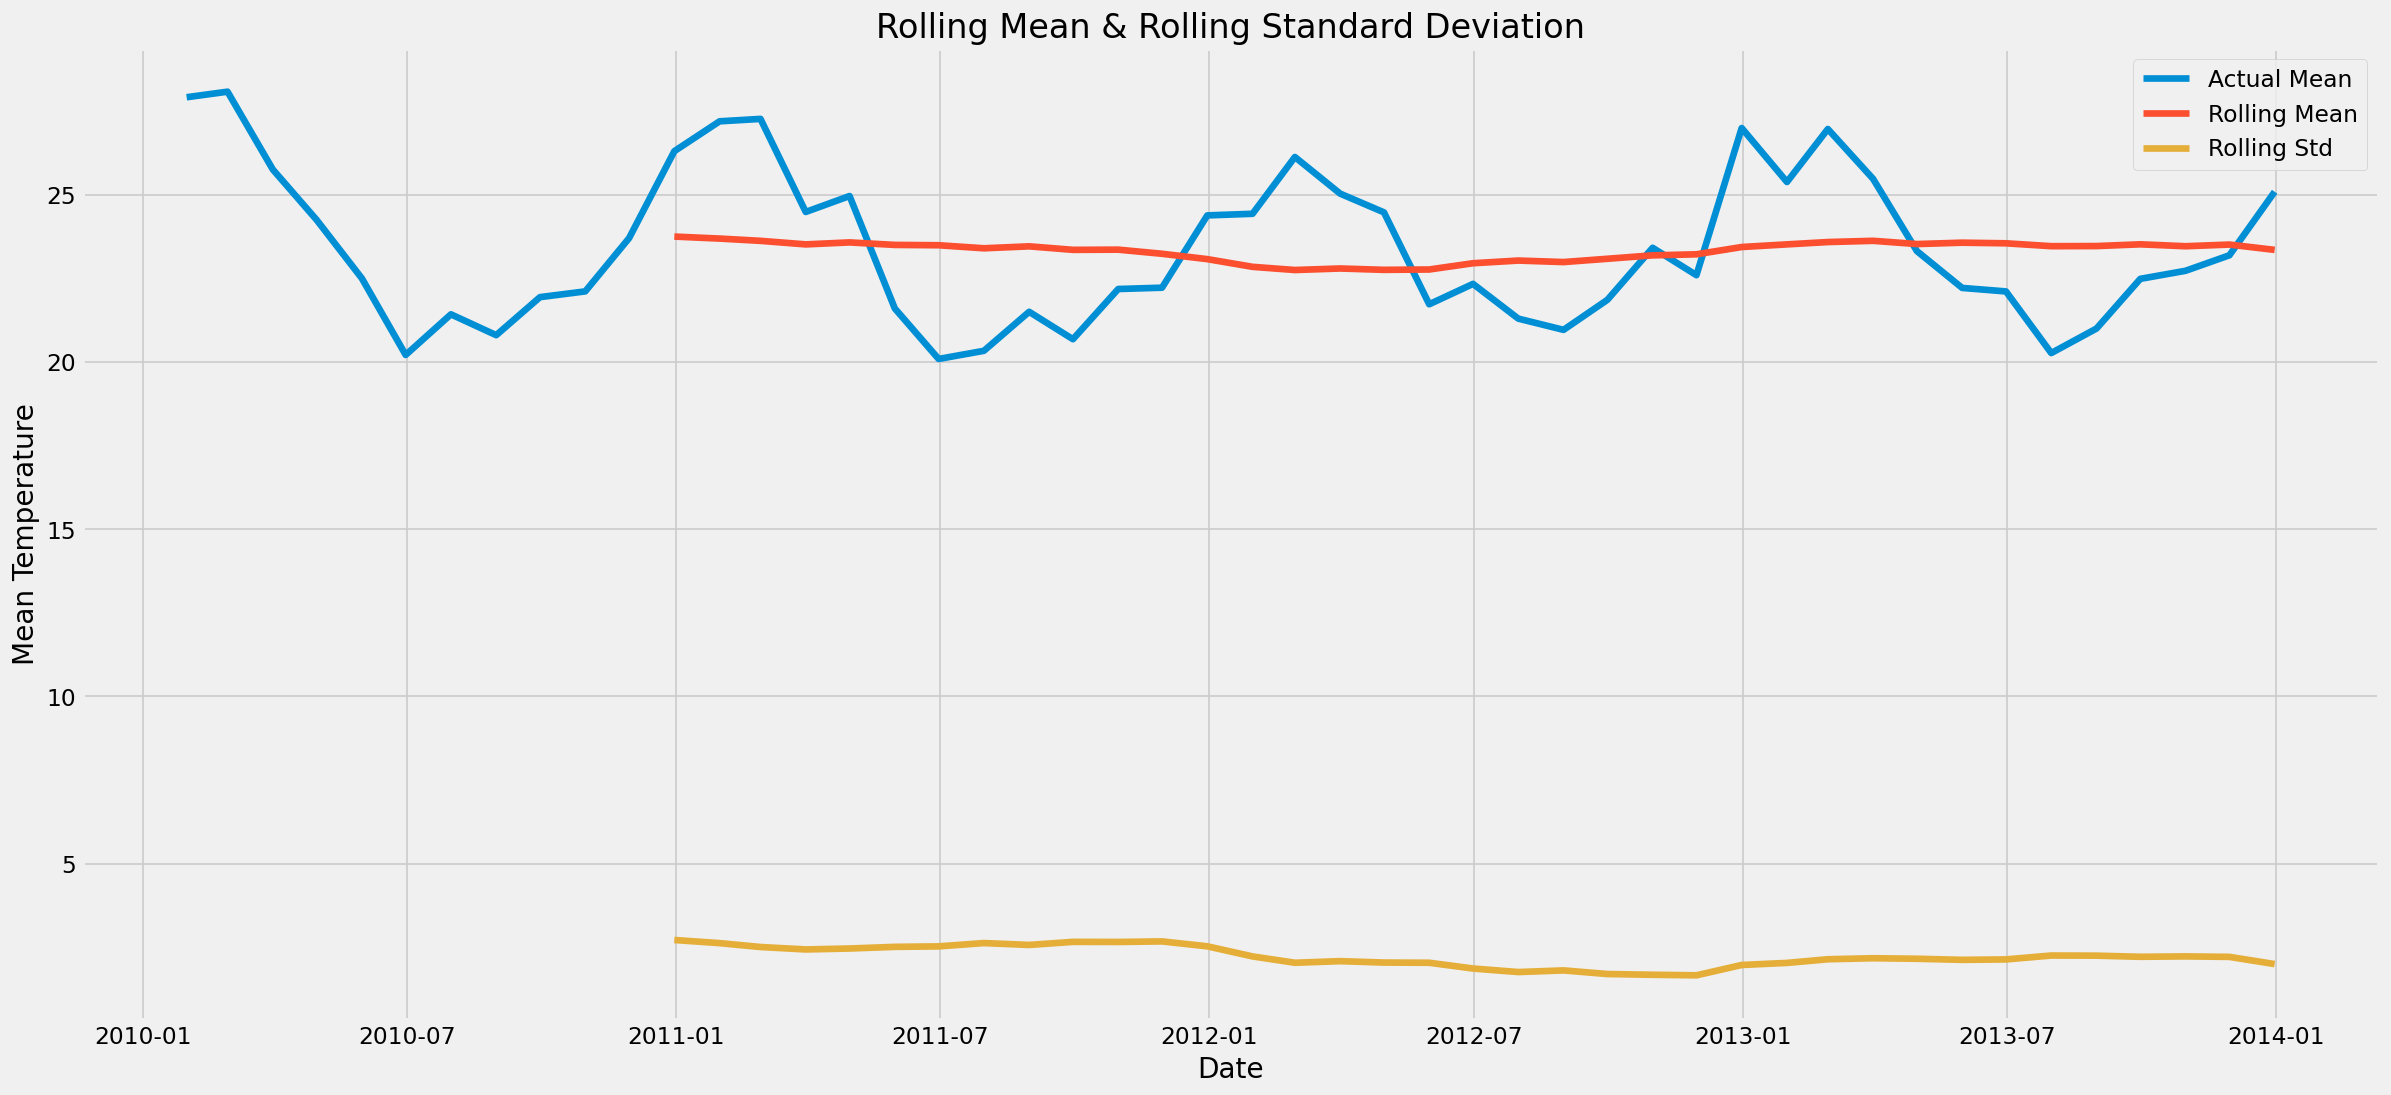

In [277]:
plot_rolling_mean_std(train_df.temp)

<h2> ARIMA Model

In [361]:
arima_model = ARIMA(train_df['temp'], order=(2, 0, 2))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                   48
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -67.738
Date:                Sat, 11 May 2024   AIC                            147.477
Time:                        02:06:27   BIC                            158.704
Sample:                    01-31-2010   HQIC                           151.720
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.4237      0.181    129.740      0.000      23.070      23.778
ar.L1          1.7370      0.010    173.900      0.000       1.717       1.757
ar.L2         -0.9980      0.003   -377.207      0.0

C:\Users\Jaymarq\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


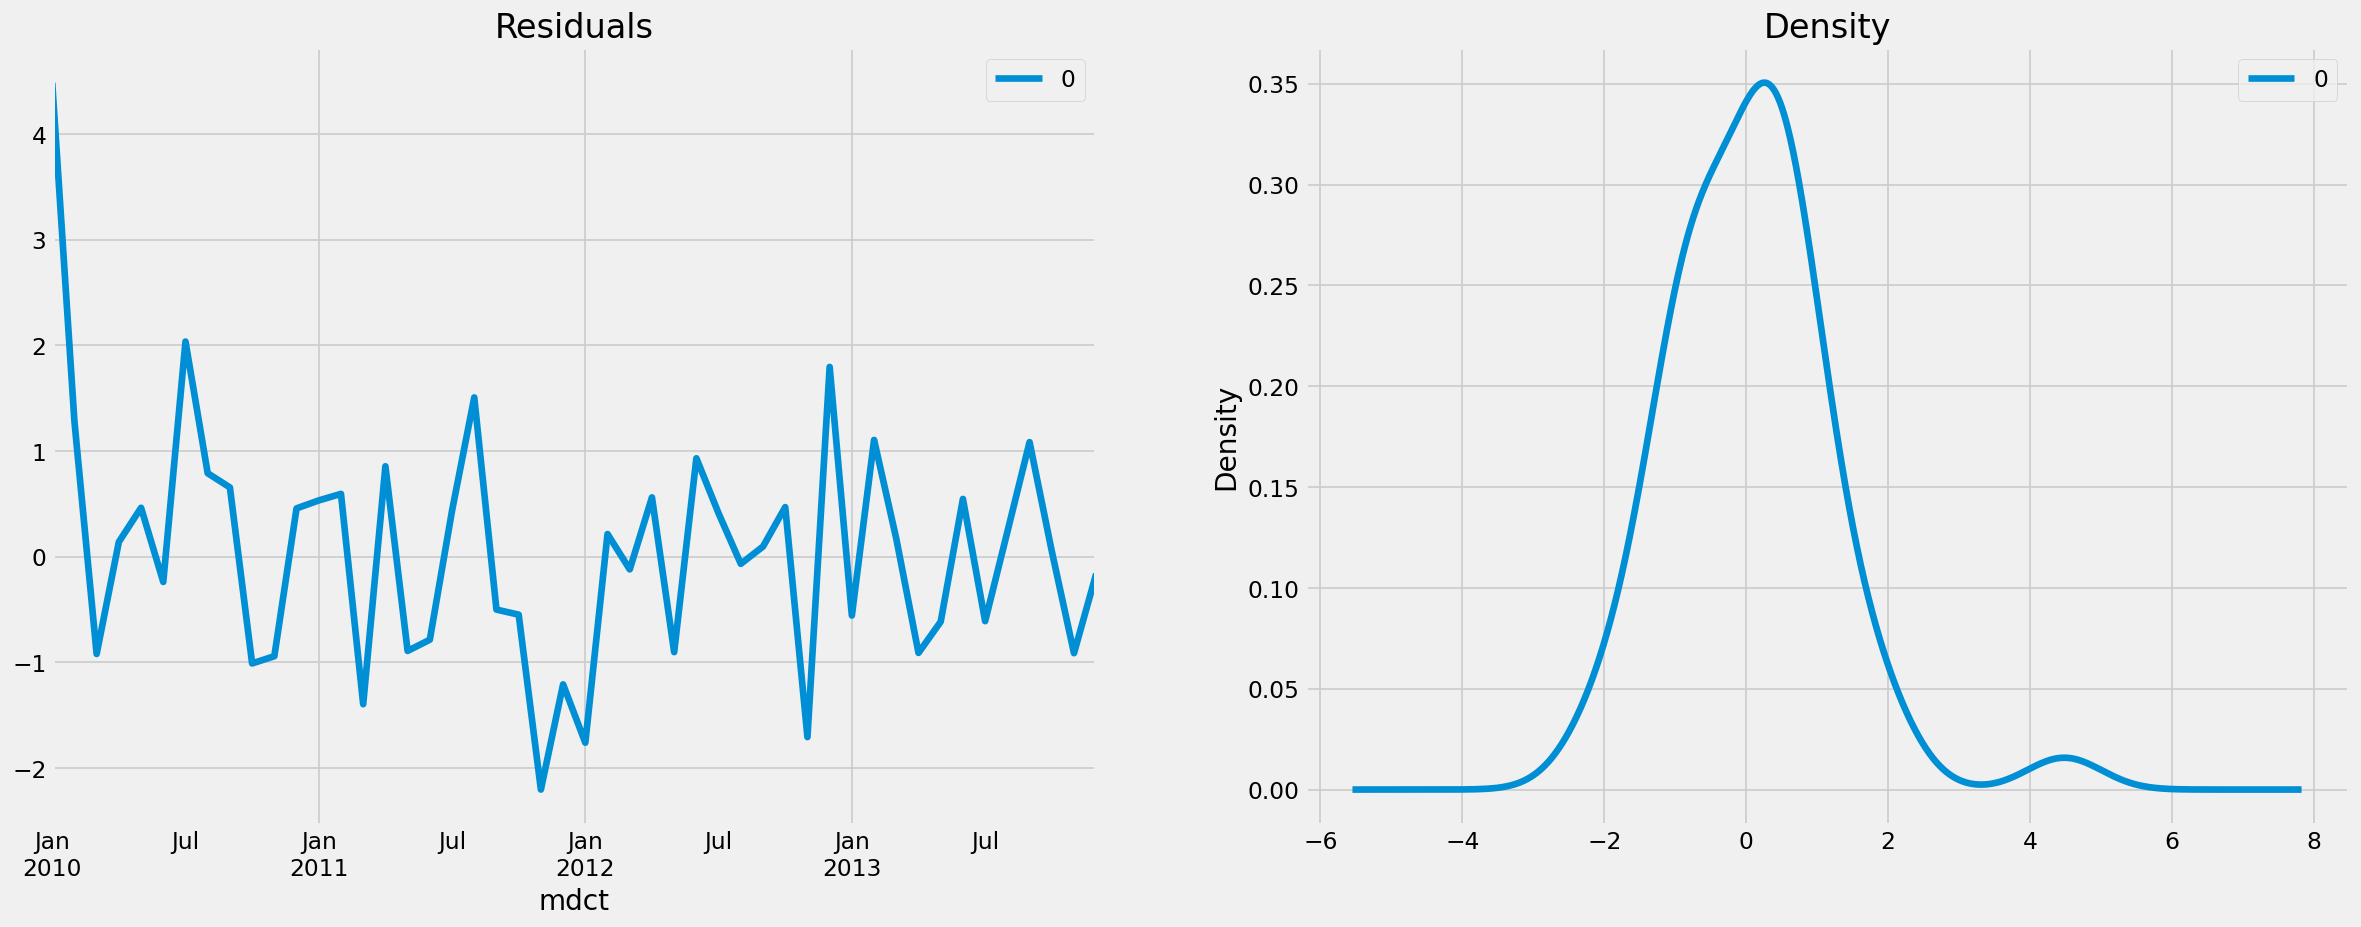

In [362]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(22,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<h3> ARIMA Model Forecast

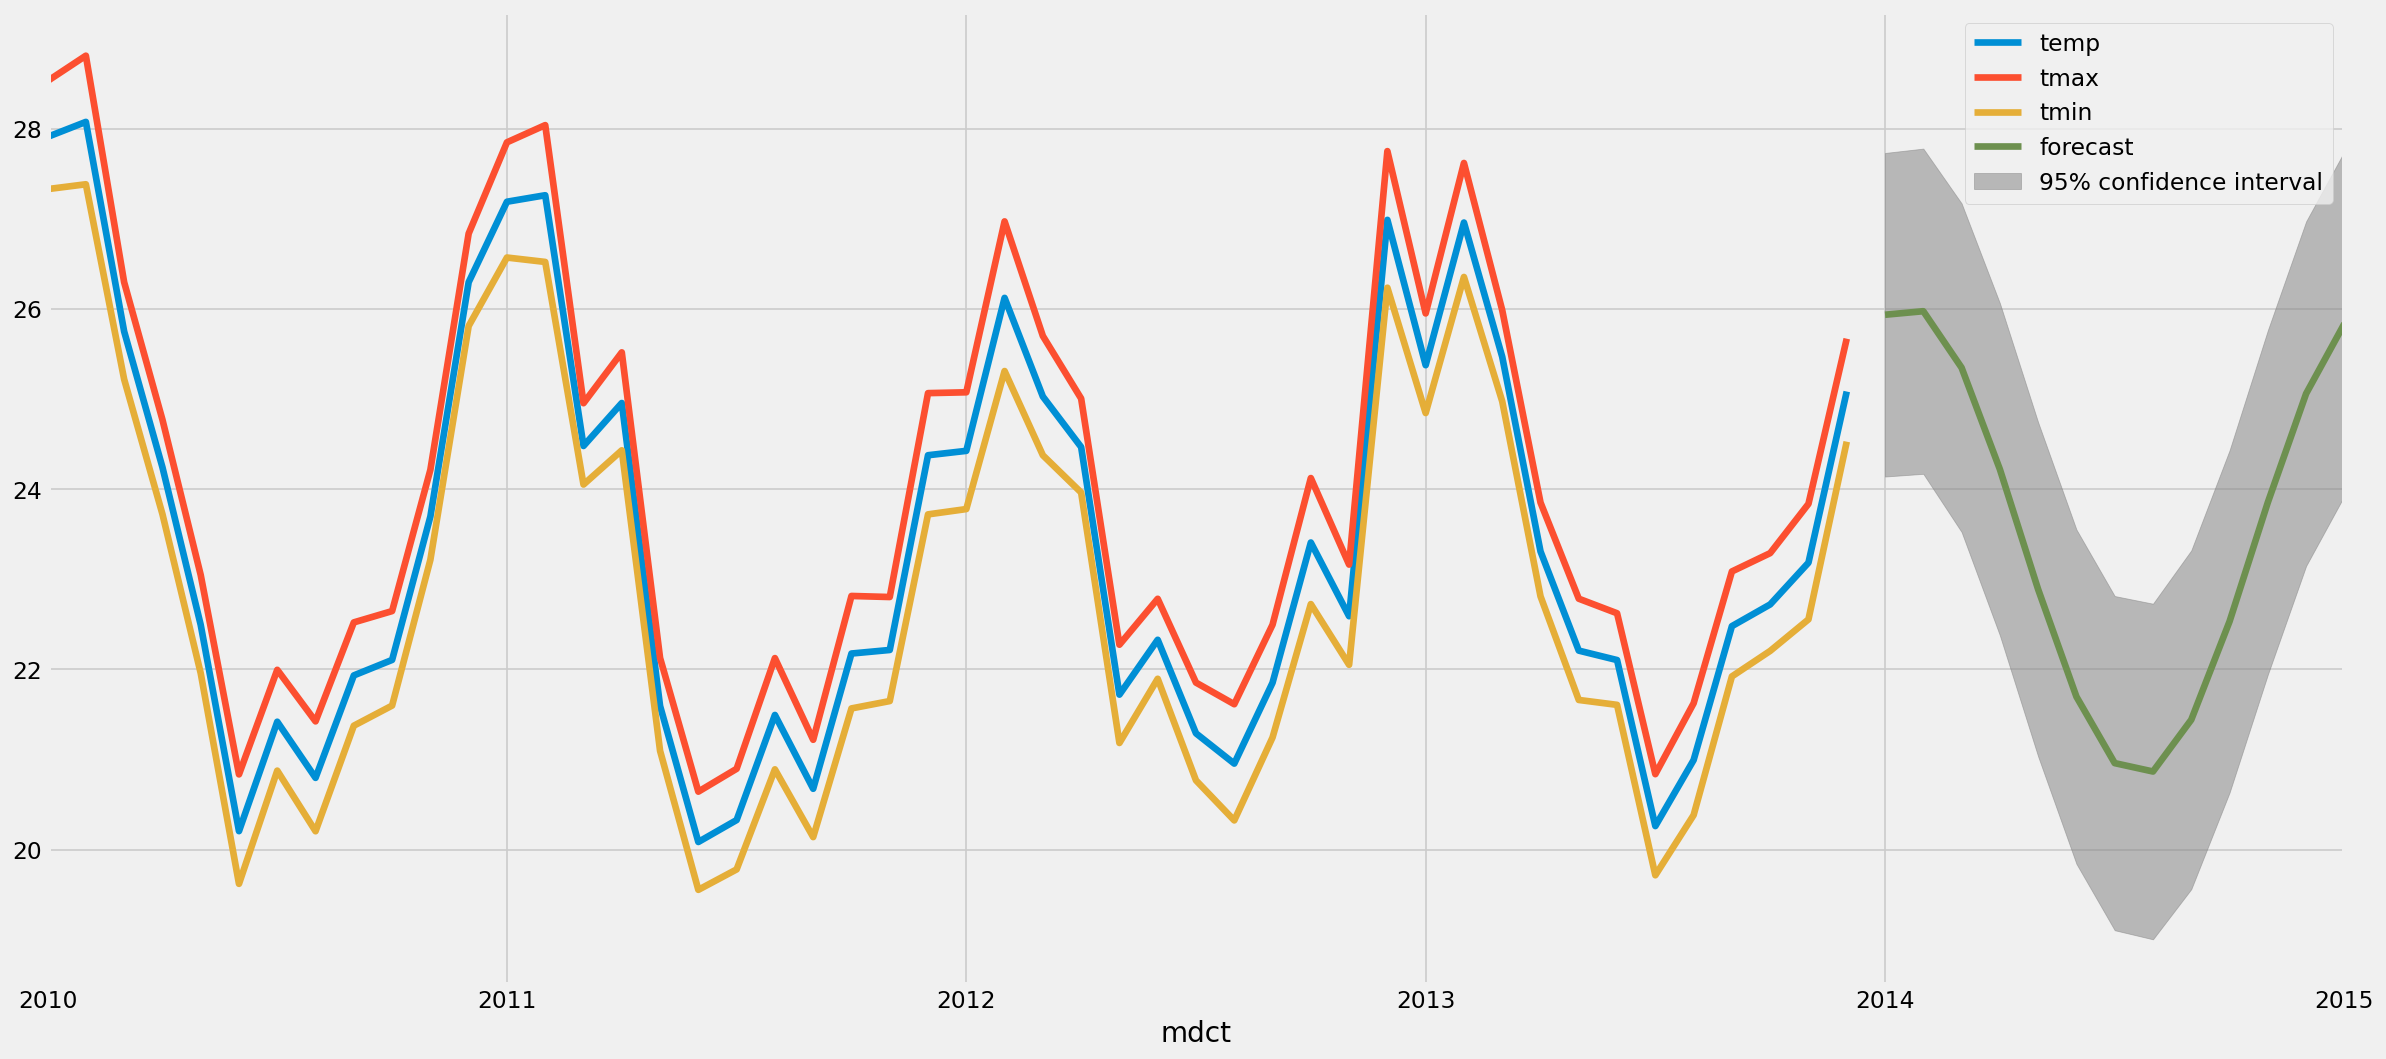

In [363]:
fig, ax = plt.subplots(figsize=(22,10))
ax = train_df.loc['2010':].plot(ax=ax)
plot_predict(arima_model_fit, '2014', '2015', ax=ax)
plt.show()

In [364]:
predictions = arima_model_fit.forecast(steps=len(test_df['temp']))

In [365]:
arima_error = mean_squared_error(test_df['temp'], predictions)
arima_mae = mean_absolute_error(test_df['temp'], predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Test Root Mean Squared Error: {error}')

Mean Absolute Error (MAE): 0.9169327020645142
Test Root Mean Squared Error: 1.0888505620421696


<h2> Deep Learning Model

In [283]:
X_train = train_df[['tmax', 'tmin']].values
y_train = train_df['temp'].values

X_test = test_df[['tmax', 'tmin']].values
y_test = test_df['temp'].values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [289]:
dl_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [290]:
dl_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [291]:
dl_model_fit = dl_model.fit(
    X_train, y_train, epochs=24, batch_size=2, verbose=1, validation_data=(X_test, y_test))

Epoch 1/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 500.5631 - mae: 22.2981 - val_loss: 454.6072 - val_mae: 21.2073
Epoch 2/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 411.5694 - mae: 20.1674 - val_loss: 310.0024 - val_mae: 17.4749
Epoch 3/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 264.0777 - mae: 16.0256 - val_loss: 109.7834 - val_mae: 10.2770
Epoch 4/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 62.6138 - mae: 7.5543 - val_loss: 6.0999 - val_mae: 1.8630
Epoch 5/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3278 - mae: 1.6843 - val_loss: 4.6330 - val_mae: 1.8949
Epoch 6/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3647 - mae: 1.8410 - val_loss: 3.6070 - val_mae: 1.6138
Epoch 7/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8978 - mae: 1.4439 - val_loss: 3.5510 - val_mae: 1.6140
Epoch 8/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9120 - mae: 1.3956 - val_loss: 3.4971 - val_mae: 1.6108
Epoch 9/24
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

In [293]:
dl_loss, dl_mae = dl_model.evaluate(X_test, y_test, verbose=0)
print(f'Mean Absolute Error (MAE):", {dl_mae}')
print(f'Test Root Mean Squared Error: {loss}')

Mean Absolute Error (MAE):", 0.8109288811683655
Test Root Mean Squared Error: 1.0970346927642822


In [360]:
dl_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)                │     17,152 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_40 (Dense)                │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_41 (Dense)                │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 57,797 (225.77 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,532 (150.52 KB)

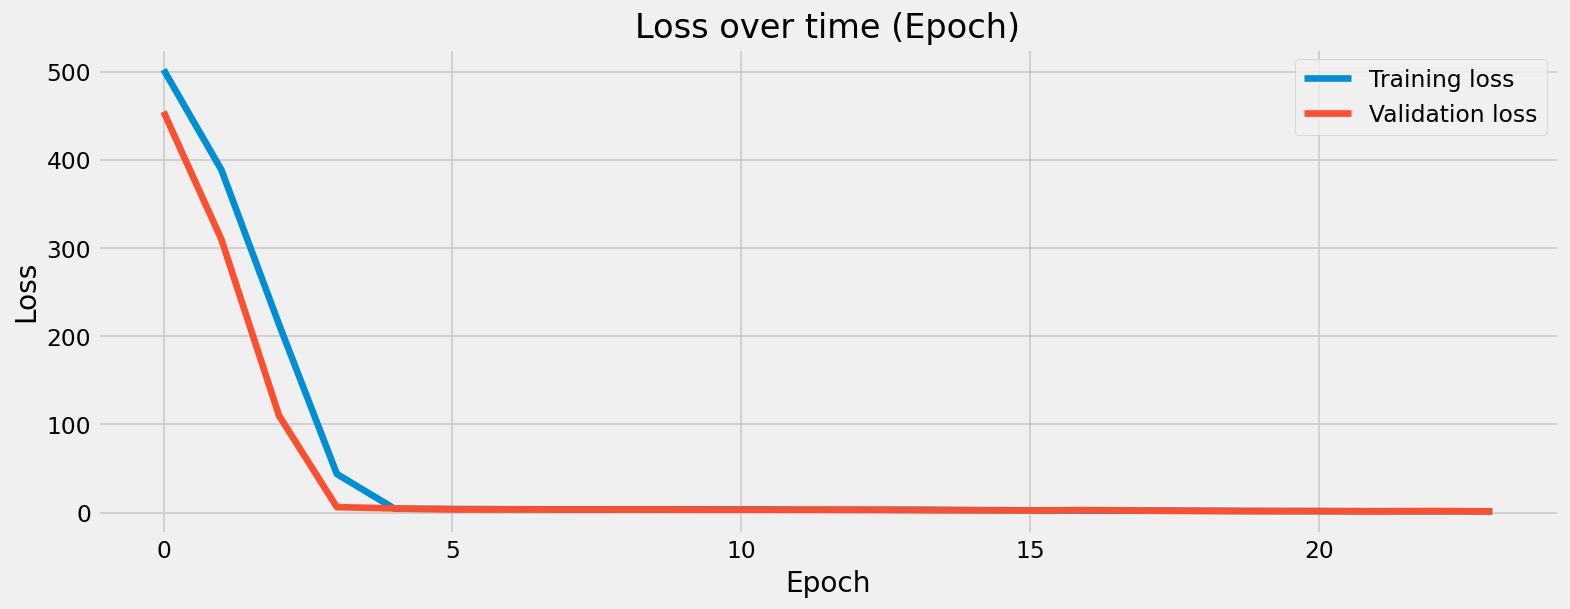

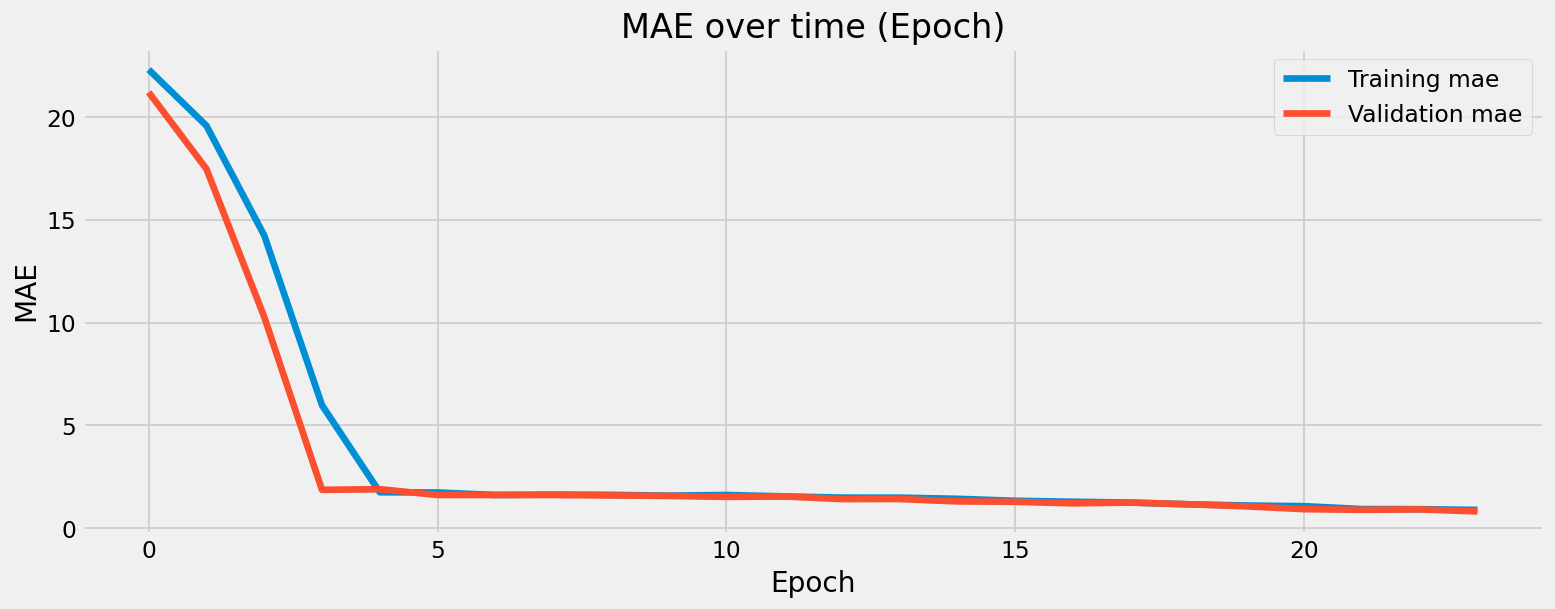

In [359]:
def plot_metrics(history, metric, title, ylabel):
    plt.figure(figsize=(14, 5))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_metrics(dl_model_fit, 'loss', 'Loss over time (Epoch)', 'Loss')
plot_metrics(dl_model_fit, 'mae', 'MAE over time (Epoch)', 'MAE')

<h3> Deep Learning Forecast

In [330]:
dl_test = dl_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [331]:
test_data_from_2014 = test_df[test_df.index.year >= 2014]
dl_pred_from_2014 = dl_test[test_df.index.year >= 2014]

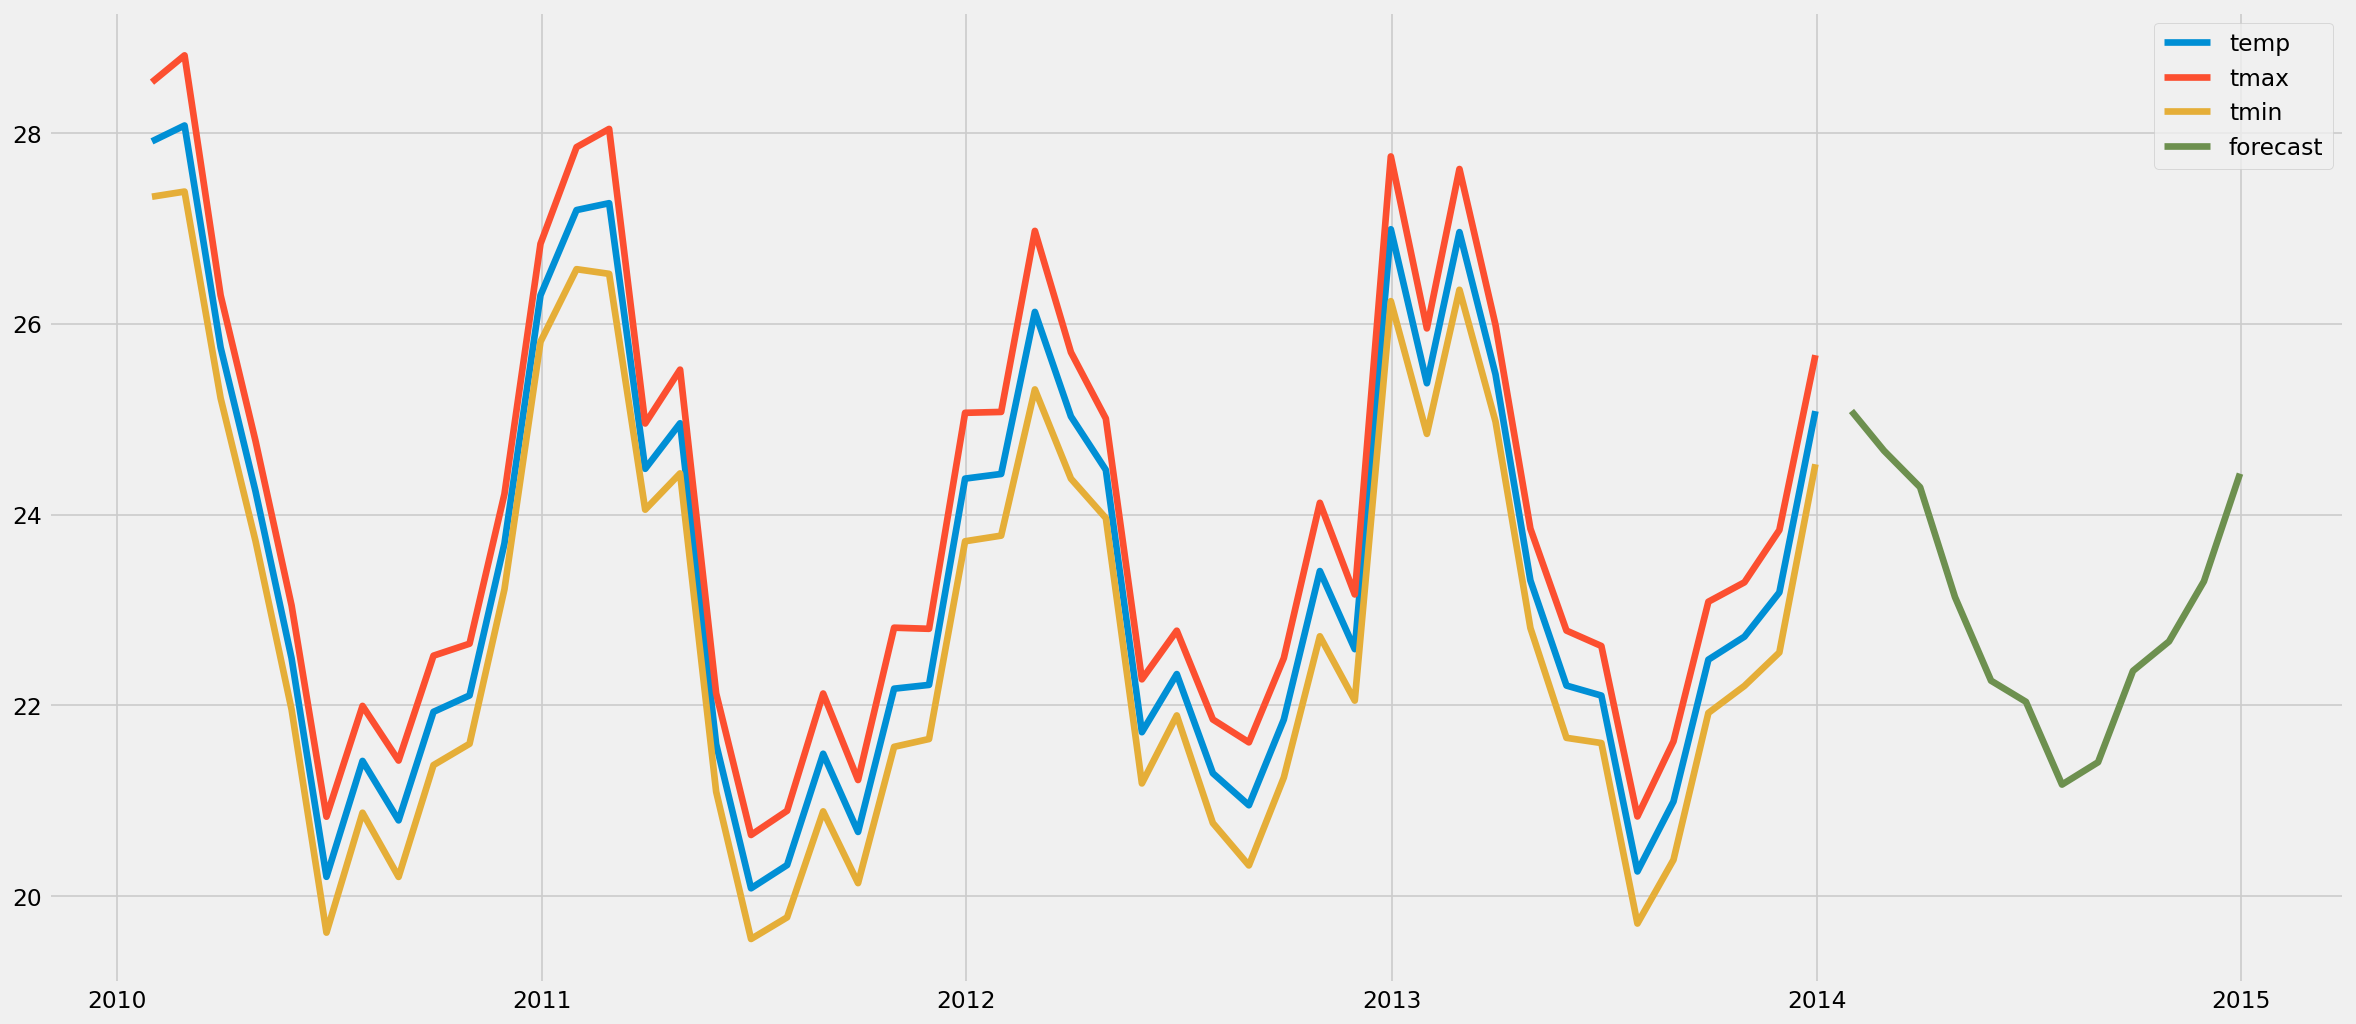

In [332]:
fig, ax = plt.subplots(figsize=(22, 10))
ax.plot(train_df.index, train_df['temp'], label='temp')
ax.plot(train_df.index, train_df['tmax'], label='tmax')
ax.plot(train_df.index, train_df['tmin'], label='tmin')
ax.plot(test_data_from_2014.index, dl_pred_from_2014, label='forecast')
ax.legend()
plt.show()

<h2> Comparison of ARIMA and Deep Learning Model

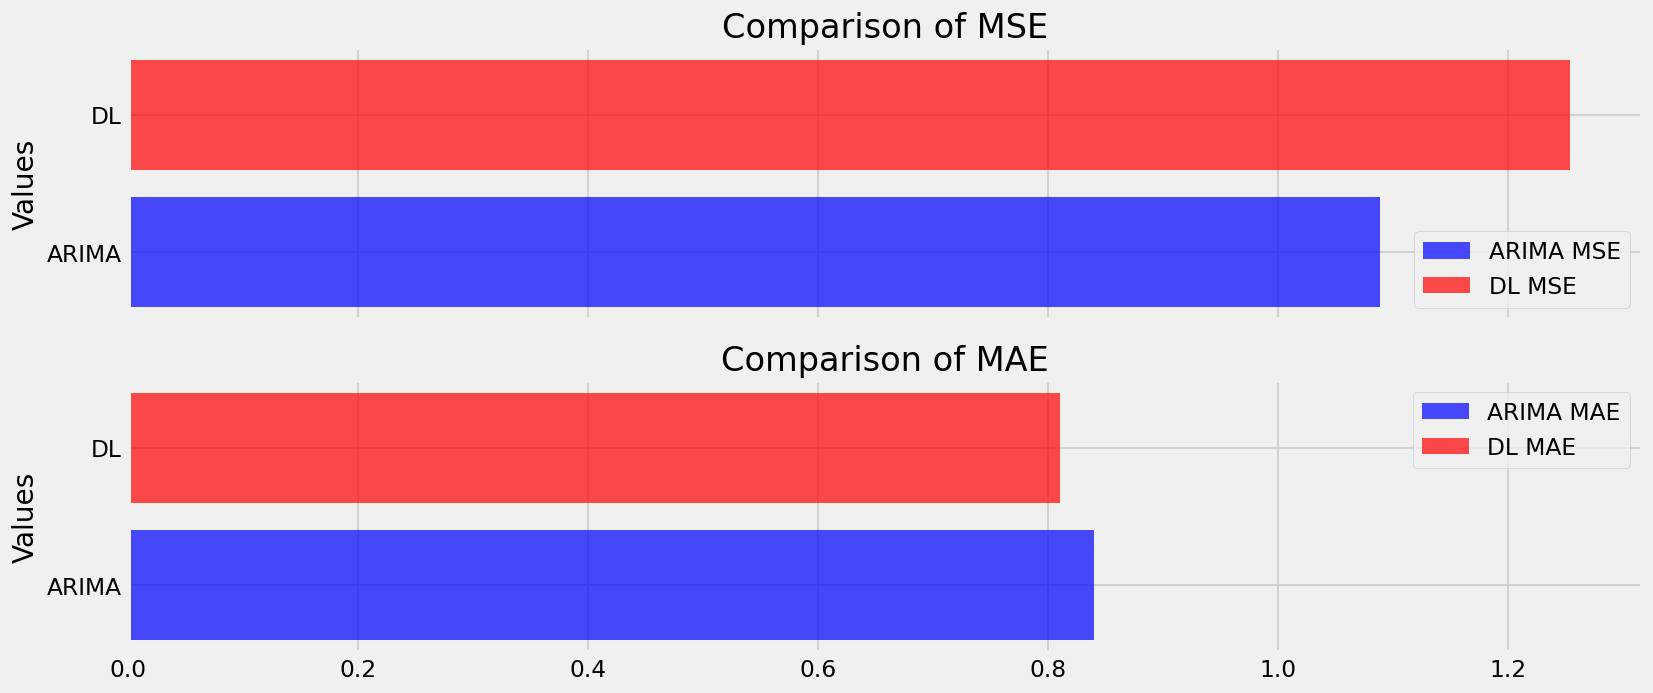

In [375]:
metrics = {
    'ARIMA': {'mse': arima_error, 'mae': arima_mae},
    'DL': {'mse': dl_loss, 'mae': dl_mae}
}

fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

for i, metric_type in enumerate(['MSE', 'MAE']):
    for j, (model, data) in enumerate(metrics.items()):
        ax = axs[i]
        ax.barh([model], [data[metric_type.lower()]], color='b' if model == 'ARIMA' else 'r', alpha=0.7, label=f'{model} {metric_type}')
        ax.set_ylabel('Values')
        ax.set_title(f'Comparison of {metric_type}')
        ax.legend()

plt.tight_layout()
plt.show()